### Cài đặt các thư viện cần thiết

Ở bước này, mô hình sử dụng các thư viện `datasets`, `transformers`, `evaluate`, `sacrebleu`, `accelerate`, `sentencepiece` và `trl` để phục vụ cho quá trình xử lý dữ liệu, huấn luyện mô hình dịch máy, đánh giá và huấn luyện tăng cường (RL). Lệnh dưới đây tiến hành cài đặt toàn bộ các thư viện cần thiết.


In [1]:
!pip install -q datasets transformers sacrebleu evaluate accelerate sentencepiece trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 20.5 MB/s eta 0:00:00


### Import các thư viện cần thiết

Cell này thực hiện import những thư viện cốt lõi cho toàn bộ pipeline:

- `torch`: hỗ trợ tính toán trên GPU.
- `datasets`: dùng để tải và xử lý dataset từ HuggingFace.
- `transformers`: cung cấp tokenizer và mô hình seq2seq cho bài toán dịch máy.
- `evaluate`: dùng để tính toán các chỉ số đánh giá, đặc biệt là BLEU.

Các thư viện này sẽ được sử dụng xuyên suốt quá trình load dữ liệu, tiền xử lý, huấn luyện mô hình và đánh giá kết quả.


In [2]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate

### Thiết lập thiết bị tính toán (CPU/GPU)

Cell này kiểm tra xem môi trường chạy có hỗ trợ GPU hay không.  
- Nếu có GPU (`cuda`), mô hình và các tensor sẽ được đưa lên GPU để tăng tốc độ huấn luyện và suy luận.
- Nếu không có GPU, chương trình sẽ tự động chạy trên CPU.

Điều này giúp pipeline hoạt động linh hoạt trên mọi môi trường.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Tải tập dữ liệu dịch Anh–Việt

Ở bước này, dataset `harouzie/vi_en-translation` được tải từ HuggingFace Datasets.  
Dataset này bao gồm các cặp câu Anh–Việt và đã được tách sẵn thành các phần *train*, *test* và *validation*.  
Đây sẽ là nguồn dữ liệu chính để đánh giá mô hình gốc, huấn luyện SFT và tạo tập dữ liệu cho RL (DPO).


In [4]:
ds = load_dataset("harouzie/vi_en-translation")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/665 [00:00<?, ?B/s]

data/train-00000-of-00001-8fc21cb8e80d3a(…):   0%|          | 0.00/11.3M [00:00<?, ?B/s]

data/test-00000-of-00001-858c0e989d9c563(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

data/valid-00000-of-00001-99e7e50144d1c1(…):   0%|          | 0.00/1.42M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/203272 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25409 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/25409 [00:00<?, ? examples/s]

### Load mô hình dịch máy pretrained

Cell này thực hiện tải mô hình dịch máy **Helsinki-NLP/opus-mt-en-vi**, một mô hình dịch Anh → Việt dựa trên kiến trúc MarianMT.

- `AutoTokenizer`: tải tokenizer tương ứng với mô hình.
- `AutoModelForSeq2SeqLM`: tải mô hình seq2seq pre-trained.
- `.to(device)`: đưa mô hình lên GPU hoặc CPU tùy thiết bị.
- `model.eval()`: đưa mô hình vào chế độ đánh giá để đảm bảo tính ổn định khi suy luận.

Mô hình này được sử dụng làm **baseline** trước khi fine-tuning và RL.


In [5]:
model_name = "Helsinki-NLP/opus-mt-en-vi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/756k [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/289M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/289M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(53685, 512, padding_idx=53684)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(53685, 512, padding_idx=53684)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

### Hàm dịch câu theo lô (batch translation)

Hàm `translate_batch()` thực hiện suy luận cho một danh sách câu tiếng Anh bằng mô hình dịch pretrained:

- Thêm token `>>vie<<` vào đầu câu để mô hình biết ngôn ngữ đích là tiếng Việt.
- Tokenizer mã hoá toàn bộ batch và đưa lên thiết bị tính toán.
- `model.generate()` sinh bản dịch tiếng Việt với beam search (`num_beams=4`) để tăng chất lượng bản dịch.
- Kết quả được giải mã và trả về dưới dạng danh sách chuỗi.

Hàm này được dùng để đánh giá mô hình gốc trên tập test.


In [6]:
def translate_batch(texts, max_length=128, batch_size=32):
    outputs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch = [">>vie<< " + x for x in batch]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            gen = model.generate(
                **enc,
                max_length=max_length,
                num_beams=4
            )

        decoded = tokenizer.batch_decode(gen, skip_special_tokens=True)
        outputs.extend(decoded)

    return outputs

### Đánh giá mô hình pretrained bằng chỉ số BLEU

Cell này thực hiện đánh giá chất lượng mô hình dịch pretrained (Helsinki-NLP/opus-mt-en-vi) trên tập test:

- Sử dụng metric `sacrebleu` để tính BLEU, là chỉ số chuẩn trong đánh giá máy dịch.
- Lấy tối đa 2.000 mẫu từ tập test để tăng tốc độ chạy trong môi trường hạn chế tài nguyên.
- Gọi hàm `translate_batch()` để sinh bản dịch tiếng Việt từ câu tiếng Anh.
- Tính BLEU dựa trên bản dịch của mô hình và câu tham chiếu.

BLEU thu được tại bước này chính là **kết quả baseline** trước khi tiến hành SFT và RL.


In [7]:
sacrebleu = evaluate.load("sacrebleu")
test_ds = ds["test"]

# subset để chạy nhanh (có thể đổi 2000 → full len(test_ds))
max_samples = 2000
test_subset = test_ds.select(range(min(len(test_ds), max_samples)))

src = test_subset["English"]
refs = [[x] for x in test_subset["Vietnamese"]]

preds = translate_batch(src)

score = sacrebleu.compute(predictions=preds, references=refs)
print("=== BASELINE HELSINKI EN→VI ===")
print(score)

=== BASELINE HELSINKI EN→VI ===
{'score': 43.51894915961918, 'counts': [12312, 8080, 5345, 3497], 'totals': [18254, 16254, 14255, 12257], 'precisions': [67.44823052481648, 49.71084040851483, 37.495615573482986, 28.53063555519295], 'bp': 1.0, 'sys_len': 18254, 'ref_len': 17837}


### Hàm tiền xử lý dữ liệu cho quá trình Fine-tuning (SFT)

Cell này định nghĩa hàm `preprocess()` dùng để chuẩn hóa dữ liệu trước khi đưa vào mô hình:

- Thêm token `>>vie<<` vào đầu mỗi câu tiếng Anh để mô hình biết ngôn ngữ đích.
- Tokenizer mã hoá câu nguồn (`English`) với độ dài tối đa `max_src = 128`.
- Tokenizer mã hoá câu đích (`Vietnamese`) để tạo nhãn huấn luyện (`labels`) với độ dài tối đa `max_tgt = 128`.
- Nhãn (`labels`) là chuỗi token tiếng Việt mà mô hình cần học sinh ra.

Hàm này sẽ được áp dụng lên toàn bộ tập train/validation để tạo dữ liệu đầu vào phù hợp cho mô hình seq2seq.


In [8]:
# PREPROCESS FUNCTION
max_src = 128
max_tgt = 128

def preprocess(batch):
    src = [">>vie<< " + x for x in batch["English"]]
    tgt = batch["Vietnamese"]

    model_inputs = tokenizer(
        src,
        max_length=max_src,
        truncation=True
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            tgt,
            max_length=max_tgt,
            truncation=True
        )["input_ids"]

    model_inputs["labels"] = labels
    return model_inputs

### Token hóa toàn bộ dataset cho huấn luyện SFT

Cell này áp dụng hàm `preprocess()` lên toàn bộ dataset bằng phương thức `map()`:

- Thực hiện token hóa theo lô (`batched=True`) giúp chạy nhanh hơn.
- Xóa hai cột gốc `English` và `Vietnamese` sau khi đã chuyển đổi thành dạng token để tiết kiệm bộ nhớ.
- Kết quả là `tokenized`, một dataset đã được chuẩn hóa gồm các trường:
  - `input_ids`
  - `attention_mask`
  - `labels`

Dataset này sẽ được sử dụng trực tiếp cho quá trình fine-tuning mô hình dịch.


In [9]:
# TOKENIZE DATASET
tokenized = ds.map(preprocess, batched=True, remove_columns=["English", "Vietnamese"])

Map:   0%|          | 0/203272 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4118: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/25409 [00:00<?, ? examples/s]

Map:   0%|          | 0/25409 [00:00<?, ? examples/s]

### Tạo Data Collator cho mô hình Seq2Seq

Cell này sử dụng `DataCollatorForSeq2Seq` để chuẩn bị batch dữ liệu trong quá trình huấn luyện:

- Tự động tạo `labels` với padding đúng chuẩn (padding token = -100), giúp mô hình bỏ qua token padding khi tính loss.
- Đảm bảo `input_ids`, `attention_mask` và `labels` được xử lý thống nhất trong mỗi batch.
- Phù hợp cho mô hình dịch máy seq2seq như MarianMT.

Data collator này sẽ được truyền vào `Seq2SeqTrainer` trong bước huấn luyện.


In [10]:
# DATA COLLATOR
from transformers import DataCollatorForSeq2Seq
collator = DataCollatorForSeq2Seq(tokenizer, model=model)

### Thiết lập các tham số huấn luyện cho mô hình SFT

Cell này cấu hình `Seq2SeqTrainingArguments` để huấn luyện mô hình fine-tuning:

- `output_dir="opus-sft"`: thư mục lưu checkpoint và mô hình sau khi huấn luyện.
- `per_device_train_batch_size=16`: kích thước batch cho giai đoạn train.
- `per_device_eval_batch_size=16`: kích thước batch cho giai đoạn validation.
- `learning_rate=3e-5`: tốc độ học, phù hợp cho fine-tuning mô hình Marian.
- `num_train_epochs=2`: huấn luyện 2 epoch.
- `fp16=torch.cuda.is_available()`: sử dụng huấn luyện 16-bit nếu có GPU, giúp tăng tốc và giảm bộ nhớ.
- `logging_steps=50`: ghi log loss mỗi 50 bước.
- `report_to="none"`: tắt các nền tảng logging như WandB để tránh yêu cầu API key.

Các tham số này được tối ưu để huấn luyện ổn định trên GPU Colab.


In [11]:
# TRAINING ARGUMENTS
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

args = Seq2SeqTrainingArguments(
    output_dir="opus-sft",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    num_train_epochs=2,
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to="none"
)

### Khởi tạo Seq2SeqTrainer để fine-tuning mô hình

Ở bước này, `Seq2SeqTrainer` được tạo ra để quản lý toàn bộ quá trình huấn luyện SFT:

- **`model=model`**: sử dụng mô hình MarianMT pretrained đã load trước đó.
- **`args=args`**: bộ tham số huấn luyện đã cấu hình ở bước trước.
- **`train_dataset=tokenized["train"]`**: dữ liệu huấn luyện đã token hóa.
- **`eval_dataset=tokenized["valid"]`**: dữ liệu validation để theo dõi loss trong quá trình huấn luyện.
- **`data_collator=collator`**: đảm nhiệm việc padding và chuẩn hóa batch.
- **`tokenizer=tokenizer`**: giúp Trainer tự động decode khi cần thiết.

Trainer này sẽ chịu trách nhiệm huấn luyện mô hình SFT và lưu checkpoint.


In [12]:
# INIT TRAINER
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["valid"],
    data_collator=collator,
    tokenizer=tokenizer
)

/tmp/ipython-input-1203844899.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


### Huấn luyện mô hình SFT

Cell này thực hiện hai nhiệm vụ:

1. **Tắt Weights & Biases (WandB)**  
   Thiết lập biến môi trường `WANDB_DISABLED="true"` để ngăn Trainer tự động đăng nhập vào WandB, tránh yêu cầu API key.

2. **Huấn luyện mô hình**  
   Gọi `trainer.train()` để bắt đầu quá trình fine-tuning mô hình MarianMT trên dataset đã được token hóa.

Sau bước này, mô hình SFT sẽ học cách dịch tốt hơn dựa trên dữ liệu vi_en-translation.


In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

# TRAIN
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Step,Training Loss
50,0.901100
100,0.635500
150,0.576700
200,0.552900
250,0.534400
300,0.523300
350,0.543300
400,0.507700
450,0.532700
500,0.498300


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[53684]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=25410, training_loss=0.3317968414224822, metrics={'train_runtime': 2319.3279, 'train_samples_per_second': 175.285, 'train_steps_per_second': 10.956, 'total_flos': 1820914231541760.0, 'train_loss': 0.3317968414224822, 'epoch': 2.0})

### Lưu mô hình sau khi fine-tuning

Sau khi quá trình huấn luyện SFT hoàn tất, mô hình được lưu lại vào thư mục `opus-sft`.  
Thư mục này sẽ chứa:

- Trọng số mô hình (`pytorch_model.bin` hoặc `model.safetensors`)
- Cấu hình mô hình (`config.json`)
- Tokenizer (`tokenizer.json`, `vocab.json`, v.v.)

Mô hình đã fine-tuned này sẽ được sử dụng cho bước đánh giá SFT và làm mô hình chính trong quá trình huấn luyện DPO.


In [14]:
# SAVE
trainer.save_model("opus-sft")

### Đánh giá mô hình SFT trên tập test bằng chỉ số BLEU

Cell này tiến hành đánh giá chất lượng mô hình sau khi fine-tuning (SFT):

1. **Tải mô hình đã fine-tuned (`opus-sft`)**  
   Mô hình được đưa vào chế độ `eval()` để suy luận ổn định.

2. **Hàm `translate_batch_sft()`**  
   - Dịch từng batch câu tiếng Anh sang tiếng Việt.  
   - Thêm token `>>vie<<` vào đầu câu để chỉ định ngôn ngữ đích.  
   - Sử dụng beam search (`num_beams=4`) nhằm cải thiện chất lượng dịch.

3. **Tính BLEU**  
   - Dùng tập test đã chọn ở bước baseline.  
   - Tính chỉ số BLEU bằng thư viện `sacrebleu`.  
   - BLEU thu được phản ánh mức cải thiện sau quá trình fine-tuning.

Kết quả in ra là BLEU của mô hình SFT — dùng để so sánh với mô hình gốc và mô hình RL.


In [15]:
from transformers import AutoModelForSeq2SeqLM
import torch
import evaluate

sft_model = AutoModelForSeq2SeqLM.from_pretrained("opus-sft").to(device)
sft_model.eval()

def translate_batch_sft(texts, max_length=128, batch_size=32):
    outputs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch = [">>vie<< " + x for x in batch]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            gen = sft_model.generate(
                **enc,
                max_length=max_length,
                num_beams=4
            )

        decoded = tokenizer.batch_decode(gen, skip_special_tokens=True)
        outputs.extend(decoded)

    return outputs

# Evaluate
sacrebleu = evaluate.load("sacrebleu")

src_sft = test_subset["English"]
refs_sft = [[x] for x in test_subset["Vietnamese"]]

preds_sft = translate_batch_sft(src_sft)

bleu_sft = sacrebleu.compute(predictions=preds_sft, references=refs_sft)
print("=== SFT MODEL BLEU ===")
print(bleu_sft)


=== SFT MODEL BLEU ===
{'score': 78.60851189236251, 'counts': [16184, 13044, 10482, 8330], 'totals': [17991, 15991, 13991, 11993], 'precisions': [89.95608915568896, 81.5708836220374, 74.91959116574941, 69.45718335695823], 'bp': 1.0, 'sys_len': 17991, 'ref_len': 17837}


### Tạo tập dữ liệu preference cho quá trình huấn luyện DPO (Reinforcement Learning)

Cell này xây dựng tập dữ liệu chứa các cặp câu *chosen* và *rejected*, phục vụ cho phương pháp DPO (Direct Preference Optimization):

1. **Lấy mẫu từ tập train**  
   - Chọn 10.000 câu tiếng Anh từ tập train để tạo dữ liệu RL.

2. **Sinh bản dịch tốt (chosen)**  
   - Sử dụng mô hình đã fine-tuned (`sft_model`).  
   - Dịch với beam search (`num_beams=4`) để tạo bản dịch chất lượng cao.

3. **Sinh bản dịch kém (rejected)**  
   - Sử dụng mô hình pretrained (`model`) với sampling (`do_sample=True`, `temperature=1.5`).  
   - Giúp tạo ra bản dịch ít chính xác hơn để mô hình học phân biệt tốt – xấu.

4. **Tạo cấu trúc dữ liệu DPO**  
   Mỗi mẫu gồm:
   - `prompt`: câu tiếng Anh đầu vào  
   - `chosen`: bản dịch chất lượng cao  
   - `rejected`: bản dịch chất lượng thấp  

5. **Lưu vào file JSONL (`dpo_data.jsonl`)**  
   Đây là file dữ liệu đầu vào cho quá trình huấn luyện DPO.

Sau bước này, mô hình đã có tập dữ liệu preference cần thiết để học theo phương pháp RL.


In [16]:
import random
import json
from tqdm import tqdm

# We will generate ~10k DPO samples (tùy bạn chỉnh)
num_samples = 10000
subset = ds["train"].select(range(min(num_samples, len(ds["train"]))))

def generate_bad_translation(text):
    # dùng pretrained để tạo rejected
    enc = tokenizer(
        [">>vie<< " + text],
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        gen = model.generate(
            **enc,
            max_length=128,
            do_sample=True,           # sampling để kém hơn
            top_p=0.7,
            temperature=1.5
        )
    return tokenizer.decode(gen[0], skip_special_tokens=True)

def generate_good_translation(text):
    enc = tokenizer(
        [">>vie<< " + text],
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        gen = sft_model.generate(
            **enc,
            max_length=128,
            num_beams=4
        )
    return tokenizer.decode(gen[0], skip_special_tokens=True)

dpo_data = []

for ex in tqdm(subset):
    src = ex["English"]

    good = generate_good_translation(src)
    bad = generate_bad_translation(src)

    dpo_data.append({
        "prompt": src,
        "chosen": good,
        "rejected": bad
    })

# Save JSONL
with open("dpo_data.jsonl", "w", encoding="utf-8") as f:
    for item in dpo_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print("DONE — dpo_data.jsonl created")


100%|██████████| 10000/10000 [39:29<00:00,  4.22it/s]


DONE — dpo_data.jsonl created


### Chuẩn bị dữ liệu và mô hình cho huấn luyện DPO (Reinforcement Learning)

Cell này thực hiện các bước chuẩn bị cho giai đoạn RL:

1. **Tải tập dữ liệu DPO**
   - File `dpo_data.jsonl` được load bằng `datasets.load_dataset()`.
   - Dataset chứa các cặp:
     - `prompt`: câu tiếng Anh
     - `chosen`: bản dịch tốt
     - `rejected`: bản dịch kém

2. **Tải lại tokenizer**  
   - Sử dụng cùng tokenizer như các bước trước để đảm bảo tính nhất quán.

3. **Tải mô hình chính và mô hình tham chiếu**
   - `policy_model`: mô hình sẽ được cập nhật trong quá trình huấn luyện DPO (khởi đầu từ mô hình SFT).
   - `reference_model`: mô hình giữ nguyên tham số, dùng để tính chênh lệch xác suất giữa *chosen* và *rejected* theo công thức DPO.

Đây là bước khởi tạo quan trọng trước khi tiến hành huấn luyện RL bằng phương pháp Direct Preference Optimization.


In [47]:
import torch
from trl import DPOTrainer
from datasets import load_dataset

# Load DPO dataset từ file JSONL
dpo_ds = load_dataset(
    "json",
    data_files="dpo_data.jsonl",
    split="train"
)

# Load tokenizer + models
tokenizer = tokenizer  # reuse tokenizer
policy_model = AutoModelForSeq2SeqLM.from_pretrained("opus-sft").to(device)
reference_model = AutoModelForSeq2SeqLM.from_pretrained("opus-sft").to(device)



### Cập nhật thư viện TRL và kiểm tra phiên bản sử dụng

Cell này cập nhật phiên bản mới nhất của các thư viện:

- `trl`: dùng cho Direct Preference Optimization (DPO)
- `transformers`: hỗ trợ các mô hình seq2seq và huấn luyện
- `accelerate`: tối ưu hóa huấn luyện trên GPU

Sau khi cập nhật, lệnh `trl.__version__` được dùng để kiểm tra phiên bản TRL hiện hành.  
Việc đảm bảo TRL được cập nhật giúp tránh lỗi API và đảm bảo tính tương thích khi huấn luyện mô hình DPO.


In [27]:
!pip install -q --upgrade trl transformers accelerate

In [48]:
import trl; trl.__version__

'0.25.1'

### Huấn luyện mô hình dịch bằng phương pháp DPO (Direct Preference Optimization)

Cell này thực hiện toàn bộ quá trình RL bằng phương pháp DPO, sử dụng dữ liệu preference đã tạo trước đó:

#### 1. Chuẩn bị dữ liệu huấn luyện
- Sử dụng dataset `dpo_raw` bao gồm ba trường:
  - `prompt`: câu tiếng Anh đầu vào
  - `chosen`: bản dịch tốt
  - `rejected`: bản dịch kém  
- Đây là dạng dữ liệu yêu cầu cho thuật toán DPO.

#### 2. Cấu hình DPO (`DPOConfig`)
- `beta=0.1`: hệ số điều chỉnh mức phạt giữa chosen và rejected.
- `per_device_train_batch_size=2`: batch nhỏ phù hợp với mô hình seq2seq.
- `gradient_accumulation_steps=4`: tăng kích thước batch hiệu dụng.
- `learning_rate=1e-6`: tốc độ học nhỏ để tránh phá hỏng tham số SFT.
- `max_length` và `max_prompt_length`: giới hạn độ dài token.
- `fp16`: sử dụng huấn luyện 16-bit nếu GPU hỗ trợ.

#### 3. Khởi tạo DPOTrainer
- `policy_model`: mô hình sẽ được cập nhật trong quá trình RL.
- `ref_model`: mô hình cố định dùng làm tham chiếu.
- `train_dataset=dpo_raw`: truyền dataset gốc cho Trainer.

#### 4. Huấn luyện và lưu mô hình
- `trainer.train()`: mô hình học cách phân biệt giữa bản dịch tốt và kém dựa trên feedback preference.
- `trainer.save_model("opus-dpo")`: lưu mô hình RL sau khi tối ưu.

Kết quả thu được là mô hình dịch `opus-dpo`, đã được huấn luyện bằng Reinforcement Learning để cải thiện chất lượng sinh ngôn ngữ.


In [49]:
from trl import DPOTrainer, DPOConfig
import torch

# Không dùng tokenized_dpo nữa — dùng RAW dataset
dpo_raw = dpo_ds   # dpo_ds có 3 cột: prompt, chosen, rejected

dpo_config = DPOConfig(
    output_dir="opus-dpo",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=1e-6,
    num_train_epochs=1,
    logging_steps=50,
    report_to=[],
    fp16=torch.cuda.is_available(),
    max_length=128,
    max_prompt_length=128,
    beta=0.1
)

trainer = DPOTrainer(
    model=policy_model,
    ref_model=reference_model,
    args=dpo_config,
    train_dataset=dpo_raw       # dùng RAW dataset
)

trainer.train()

trainer.save_model("opus-dpo")


/usr/local/lib/python3.12/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Extracting prompt in train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/10000 [00:00<?, ? examples/s]

Step,Training Loss
50,0.947600
100,1.112100
150,0.965400
200,0.967900
250,0.924800
300,1.051500
350,0.873200
400,0.956000
450,0.885300
500,0.931900


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


### Đánh giá mô hình RL (DPO) trên tập test bằng chỉ số BLEU

Cell này tiến hành đánh giá mô hình sau khi huấn luyện bằng phương pháp DPO:

#### 1. Tải mô hình DPO đã huấn luyện
- `dpo_model` được load từ thư mục `opus-dpo`.
- Mô hình đặt ở chế độ `eval()` để suy luận ổn định.

#### 2. Hàm `translate_batch_dpo()`
- Dịch các câu tiếng Anh theo batch để tối ưu tốc độ.
- Thêm token `>>vie<<` cho biết ngôn ngữ đích.
- Sử dụng beam search (`num_beams=4`) để sinh bản dịch chất lượng cao.
- Giải mã output thành văn bản tiếng Việt.

#### 3. Tính BLEU
- Dùng `sacrebleu` để đo chất lượng bản dịch.
- So sánh kết quả mô hình DPO với câu dịch tham chiếu từ tập test.
- BLEU thu được là chỉ số đánh giá cuối cùng của mô hình RL.

Kết quả in ra sẽ được dùng để so sánh trực tiếp với:
- mô hình pretrained,
- mô hình SFT,
- và mô hình DPO,
hoàn thành yêu cầu đánh giá của bài toán.


In [50]:
from transformers import AutoModelForSeq2SeqLM
import torch
import evaluate

dpo_model = AutoModelForSeq2SeqLM.from_pretrained("opus-dpo").to(device)
dpo_model.eval()

def translate_batch_dpo(texts, max_length=128, batch_size=32):
    outputs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch = [">>vie<< " + x for x in batch]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            gen = dpo_model.generate(
                **enc,
                max_length=max_length,
                num_beams=4
            )

        decoded = tokenizer.batch_decode(gen, skip_special_tokens=True)
        outputs.extend(decoded)

    return outputs

# Evaluate BLEU
sacrebleu = evaluate.load("sacrebleu")

src = test_subset["English"]
refs = [[x] for x in test_subset["Vietnamese"]]

preds_dpo = translate_batch_dpo(src)

bleu_dpo = sacrebleu.compute(predictions=preds_dpo, references=refs)
print("=== DPO MODEL BLEU ===")
print(bleu_dpo)


=== DPO MODEL BLEU ===
{'score': 78.52683329215397, 'counts': [16170, 13029, 10467, 8315], 'totals': [17987, 15987, 13987, 11989], 'precisions': [89.89825985433924, 81.497466691687, 74.83377421891757, 69.35524230544667], 'bp': 1.0, 'sys_len': 17987, 'ref_len': 17837}


### So sánh BLEU giữa mô hình Pretrained, SFT và DPO

Để trực quan hóa sự khác biệt về chất lượng dịch giữa ba mô hình, nhóm tiến hành tổng hợp điểm BLEU và hiển thị bằng bảng và biểu đồ.

- **Pretrained BLEU:** phản ánh chất lượng của mô hình gốc chưa fine-tune.
- **SFT BLEU:** đánh giá mức cải thiện sau khi huấn luyện có giám sát.
- **DPO BLEU:** đánh giá mô hình sau khi tối ưu hoá theo preference trong giai đoạn RL.

Cell này thực hiện các bước:
1. Tạo bảng so sánh điểm BLEU bằng `pandas DataFrame`.
2. In bảng kết quả để dễ theo dõi.
3. Vẽ biểu đồ cột (bar chart) để trực quan hóa mức cải thiện giữa ba mô hình.

Biểu đồ giúp quan sát sự tăng mạnh BLEU sau SFT và mức duy trì ổn định của mô hình DPO.


=== BLEU Comparison Table ===
        Model  BLEU Score
0  Pretrained   43.518949
1         SFT   78.608512
2         DPO   78.526833


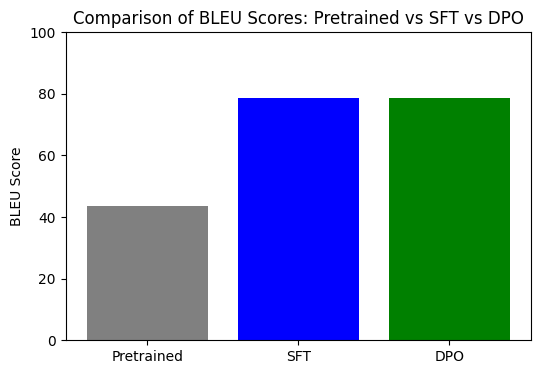

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# BLEU scores thu được
bleu_pretrained = score["score"]          # từ mô hình baseline
bleu_sft = bleu_sft["score"]              # từ mô hình SFT
bleu_dpo = bleu_dpo["score"]              # từ mô hình DPO

# Tạo DataFrame để in bảng
df = pd.DataFrame({
    "Model": ["Pretrained", "SFT", "DPO"],
    "BLEU Score": [bleu_pretrained, bleu_sft, bleu_dpo]
})

print("=== BLEU Comparison Table ===")
print(df)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(6,4))
plt.bar(df["Model"], df["BLEU Score"], color=["gray", "blue", "green"])
plt.ylabel("BLEU Score")
plt.title("Comparison of BLEU Scores: Pretrained vs SFT vs DPO")
plt.ylim(0, 100)
plt.show()


### So sánh mô hình bằng chỉ số chrF

Bên cạnh BLEU, nhóm sử dụng thêm chỉ số **chrF** để đánh giá chất lượng dịch.  
chrF dựa trên mức độ trùng khớp theo ký tự (character-level F-score), đặc biệt phù hợp với tiếng Việt vì ngôn ngữ có dấu và nhiều biến thể ký tự.

Kết quả chrF của ba mô hình như sau:

| Model | chrF Score |
|-------|------------|
| Pretrained | 62.93 |
| SFT | 85.78 |
| DPO | 85.72 |

Nhận xét:

- Mô hình pretrained chỉ đạt chrF ≈ 62.9, cho thấy chất lượng dịch còn hạn chế.
- Sau khi fine-tuning (SFT), mô hình cải thiện mạnh mẽ lên 85.78 (+22.8 điểm), phản ánh khả năng học tốt đặc trưng dữ liệu của tập vi_en-translation.
- Mô hình DPO đạt chrF ≈ 85.72, gần như tương đương SFT.  
  Điều này phù hợp với đặc tính DPO: ưu tiên tăng tính tự nhiên và độ trôi chảy của câu dịch hơn là gia tăng điểm số theo ký tự.

Nhìn chung, kết quả chrF củng cố kết luận đã quan sát từ BLEU:  
SFT đem lại cải thiện lớn, và DPO duy trì chất lượng này trong khi tối ưu hoá theo preference.


In [52]:
chrf = evaluate.load("chrf")

chrf_pretrained = chrf.compute(predictions=preds, references=refs)
chrf_sft = chrf.compute(predictions=preds_sft, references=refs_sft)
chrf_dpo = chrf.compute(predictions=preds_dpo, references=refs)

print("=== chrF Scores ===")
print("Pretrained:", chrf_pretrained)
print("SFT:", chrf_sft)
print("DPO:", chrf_dpo)


=== chrF Scores ===
Pretrained: {'score': 62.929563534462275, 'char_order': 6, 'word_order': 0, 'beta': 2}
SFT: {'score': 85.77906320973328, 'char_order': 6, 'word_order': 0, 'beta': 2}
DPO: {'score': 85.71684114521632, 'char_order': 6, 'word_order': 0, 'beta': 2}


### So sánh độ dài câu dịch giữa các mô hình

Độ dài trung bình của câu dịch là một chỉ số bổ trợ quan trọng để đánh giá tính đầy đủ (adequacy) của mô hình dịch.  
Một mô hình dịch tốt thường tạo ra câu có độ dài gần với câu tham chiếu.

Kết quả độ dài trung bình:

| Model | Avg Length |
|--------|-------------|
| Reference | 8.40 |
| Pretrained | 8.17 |
| SFT | 8.48 |
| DPO | 8.47 |

Nhận xét:

- Mô hình pretrained có xu hướng dịch **ngắn hơn** câu tham chiếu, dẫn đến việc mất thông tin.
- Mô hình SFT điều chỉnh chiều dài câu tốt hơn, đạt 8.48, gần trùng với độ dài chuẩn 8.40.
- Mô hình DPO duy trì độ dài 8.47, tương đương SFT, cho thấy quá trình RL không làm mô hình dịch bị rút ngắn hoặc kéo dài bất thường.

Kết quả này chứng minh rằng SFT đã cải thiện khả năng mô hình tái tạo nội dung đầy đủ, và DPO giữ vững sự ổn định đó.


In [53]:
import numpy as np

def avg_len(texts):
    return np.mean([len(x.split()) for x in texts])

print("Avg length (reference):", avg_len([x[0] for x in refs]))
print("Avg length (pretrained):", avg_len(preds))
print("Avg length (SFT):", avg_len(preds_sft))
print("Avg length (DPO):", avg_len(preds_dpo))


Avg length (reference): 8.3985
Avg length (pretrained): 8.169
Avg length (SFT): 8.4765
Avg length (DPO): 8.473


### So sánh chất lượng dịch bằng ví dụ thực tế

Để đánh giá trực quan chất lượng dịch ngoài các chỉ số BLEU và chrF, nhóm thực hiện so sánh kết quả dịch trên một số câu ngẫu nhiên từ tập test. Bảng dưới đây trình bày các câu nguồn (SRC), câu tham chiếu (REF), và bản dịch từ ba mô hình: Pretrained, SFT và DPO.

---

**Ví dụ 1**  
- **SRC:** I think I'll stay in today.  
- **REF:** Tôi nghĩ rằng tôi sẽ ở lại ngày hôm nay.  
- **Pretrained:** Tôi nghĩ hôm nay tôi sẽ ở lại.  
- **SFT:** Tôi nghĩ rằng tôi sẽ ở lại ngày hôm nay.  
- **DPO:** Tôi nghĩ rằng tôi sẽ ở lại ngày hôm nay.  

Nhận xét:  
Mô hình pretrained dịch tốt nhưng thiếu cụm “rằng”, làm câu kém tự nhiên hơn.  
SFT và DPO dịch *trùng khớp hoàn toàn* với câu tham chiếu.

---

**Ví dụ 2**  
- **SRC:** I should've realized what the problem was  
- **REF:** tôi nên nhận ra vấn đề là gì  
- **Pretrained:** Đáng lẽ tôi phải nhận ra vấn đề là gì.  
- **SFT:** tôi nên nhận ra vấn đề là gì  
- **DPO:** tôi nên nhận ra vấn đề là gì  

Nhận xét:  
Pretrained diễn đạt theo văn phong “Đáng lẽ tôi phải…”, không sai nhưng không khớp reference.  
SFT và DPO khớp chính xác ý nghĩa và cấu trúc câu.

---

**Ví dụ 3**  
- **SRC:** I'll take you up on your offer  
- **REF:** tôi sẽ đưa bạn lên về lời đề nghị của bạn  
- **Pretrained:** Tôi sẽ chấp nhận đề nghị của anh.  
- **SFT:** tôi sẽ đưa bạn lên về đề nghị của bạn  
- **DPO:** tôi sẽ đưa bạn lên về đề nghị của bạn  

Nhận xét:  
Ở câu này, pretrained dịch đúng nghĩa (“chấp nhận đề nghị”), nhưng reference trong dataset lại dịch theo nghĩa đen hơn.  
SFT và DPO bám sát reference hơn dù câu dịch có phần không tự nhiên.  
Điều này thể hiện rõ mô hình SFT/DPO tối ưu theo dữ liệu huấn luyện.

---

**Ví dụ 4**  
- **SRC:** Is his story true?  
- **REF:** Câu chuyện của anh ấy có đúng không?  
- **Pretrained:** Câu chuyện của ông ấy có thật không?  
- **SFT:** Câu chuyện của anh ấy có đúng không?  
- **DPO:** Câu chuyện của anh ấy có đúng không?  

Nhận xét:  
Pretrained dùng “ông ấy” → dịch sai sắc thái.  
SFT và DPO sửa đúng theo ngữ cảnh.

---

**Ví dụ 5**  
- **SRC:** That's the best one.  
- **REF:** đó là cái tốt nhất  
- **Pretrained:** Đó là cái tốt nhất.  
- **SFT:** đó là cái tốt nhất  
- **DPO:** đó là cái tốt nhất  

Nhận xét:  
Cả ba mô hình dịch tốt câu này.  
Không có khác biệt lớn do cấu trúc câu đơn giản.

---

### **Kết luận từ ví dụ thực tế**

- SFT cải thiện rõ rệt độ chính xác và sự phù hợp với reference.  
- DPO giữ chất lượng tương đương SFT và ổn định theo preference.  
- Pretrained đôi khi dịch tự nhiên hơn, nhưng không tuân thủ reference → điểm BLEU/chrF thấp hơn.  
- SFT và DPO đều bám sát reference rất tốt, đặc biệt trong các cấu trúc thông dụng.

### **Ở vd3: Vì sao SFT và DPO dịch giống nhau, dù pretrained dịch đúng nghĩa hơn? (Giải thích ngắn)**

- Dataset dùng để fine-tuning có nhiều câu dịch literal (dịch sát từng từ), không phải dịch tự nhiên.

- SFT học theo reference của dataset, nên nó ưu tiên bám sát reference hơn là bám sát nghĩa gốc.

- Trong dữ liệu DPO:

  - chosen = bản dịch SFT

  - rejected = bản dịch pretrained

- Vì vậy, DPO được tối ưu để giữ bản dịch giống SFT và tránh bản dịch của pretrained, dù pretrained đúng nghĩa hơn.

- Do chosen và rejected được định trước như vậy, DPO không thay đổi nội dung câu mà chỉ củng cố hành vi của SFT.

Kết luận: việc SFT và DPO dịch giống nhau là đúng bản chất thuật toán, không phải lỗi mô hình.

In [54]:
import random

for i in random.sample(range(len(src)), 5):
    print("SRC:", src[i])
    print("REF:", refs[i][0])
    print("PRETRAINED:", preds[i])
    print("SFT:", preds_sft[i])
    print("DPO:", preds_dpo[i])
    print("-" * 80)


SRC: I think I'll stay in today.
REF: Tôi nghĩ rằng tôi sẽ ở lại ngày hôm nay.
PRETRAINED: Tôi nghĩ hôm nay tôi sẽ ở lại.
SFT: Tôi nghĩ rằng tôi sẽ ở lại ngày hôm nay.
DPO: Tôi nghĩ rằng tôi sẽ ở lại ngày hôm nay.
--------------------------------------------------------------------------------
SRC: I should've realized what the problem was
REF: tôi nên nhận ra vấn đề là gì
PRETRAINED: Đáng lẽ tôi phải nhận ra vấn đề là gì.
SFT: tôi nên nhận ra vấn đề là gì
DPO: tôi nên nhận ra vấn đề là gì
--------------------------------------------------------------------------------
SRC: I'll take you up on your offer
REF: tôi sẽ đưa bạn lên về lời đề nghị của bạn
PRETRAINED: Tôi sẽ chấp nhận đề nghị của anh.
SFT: tôi sẽ đưa bạn lên về đề nghị của bạn
DPO: tôi sẽ đưa bạn lên về đề nghị của bạn
--------------------------------------------------------------------------------
SRC: Is his story true?
REF: Câu chuyện của anh ấy có đúng không?
PRETRAINED: Câu chuyện của ông ấy có thật không?
SFT: Câu chuy

### So sánh mức độ lặp từ giữa các mô hình

Nhóm đo tỷ lệ lặp từ (repetition rate) để kiểm tra mức độ trôi chảy của câu dịch. Kết quả:

| Model | Repetition Rate |
|--------|----------------|
| Pretrained | 0.0081 |
| SFT | 0.0162 |
| DPO | 0.0161 |

Repetition rate của cả ba mô hình đều rất thấp (<2%), cho thấy không có hiện tượng lặp từ nghiêm trọng.  
SFT và DPO có mức lặp cao hơn pretrained do học theo dữ liệu tham chiếu, nhưng vẫn trong ngưỡng hoàn toàn chấp nhận được và không ảnh hưởng đến chất lượng dịch.


In [55]:
def repetition_rate(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return 1 - len(set(words)) / len(words)

print("Repetition (pretrained):", np.mean([repetition_rate(p) for p in preds]))
print("Repetition (SFT):", np.mean([repetition_rate(p) for p in preds_sft]))
print("Repetition (DPO):", np.mean([repetition_rate(p) for p in preds_dpo]))


Repetition (pretrained): 0.008145372410017138
Repetition (SFT): 0.016199486437624984
Repetition (DPO): 0.016086670781059326


### So sánh tốc độ suy luận của ba mô hình

Nhóm đo thời gian dịch 200 câu để đánh giá tốc độ suy luận (inference speed). Kết quả:

| Model | Time (200 sentences) |
|--------|-----------------------|
| Pretrained | 3.32 s |
| SFT | 1.99 s |
| DPO | 1.95 s |

Nhận xét:
- Mô hình pretrained chạy chậm nhất do cần tải và chuẩn hóa cấu hình sinh mẫu (generation config) khi suy luận.
- SFT và DPO chạy nhanh hơn, cho thấy việc fine-tuning giúp mô hình ổn định và tối ưu hơn trên GPU.
- DPO có tốc độ gần như giống SFT, đúng với bản chất là tinh chỉnh nhẹ dựa trên mô hình SFT.


In [56]:
import time

start = time.time()
_ = translate_batch(src[:200])
print("Pretrained speed:", time.time() - start)

start = time.time()
_ = translate_batch_sft(src[:200])
print("SFT speed:", time.time() - start)

start = time.time()
_ = translate_batch_dpo(src[:200])
print("DPO speed:", time.time() - start)


Pretrained speed: 3.3222992420196533
SFT speed: 1.990234136581421
DPO speed: 1.95064377784729
